### Construct precinct file with district splits, add population and vote data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_columns', None)

import numpy as np
import json
import networkx as nx
import math
import random

import maup
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
maup.progress.enabled = True

import shapely

from tqdm import tqdm

### Multnomah County precinct file with ALL district splits:

In [2]:
precincts_multnomah_all_splits_df = gpd.read_file("./Data/Shapefiles/Multnomah precincts 2024/Multnomah_Elections_Precinct_Split_2024.shp")

In [3]:
precincts_multnomah_all_splits_df

,OR_House,OR_Senate,Unincorp,METRO,Mult_Comm,CITY,TRAN_DIST,FIRE_DIST,WaterDist,SewerDist,SchoolDist,PUD,CommColleg,Soil_Water,USCongress,ESD,CoP_Dist,UFSWQD,Precinct,Split,Shape_Leng,Shape_Area,geometry
0,House District 44,Senate District 22,Multnomah Co Unincorporated,Metro District 5,Multnomah Co Commissioner District 4,None,Tri-County Metropolitan Transportation Distric...,None,None,None,Reynolds School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 5,None,None,4407,C,34012.975023,4.729440e+07,"POLYGON ((7678756.031 703492.129, 7678614.458 ..."
1,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 4,1,None,4407,A,27449.132678,1.971331e+07,"POLYGON ((7655881.390 715353.419, 7659490.186 ..."
2,House District 41,Senate District 21,None,Metro District 6,Multnomah Co Commissioner District 3,City of Milwaukie,Tri-County Metropolitan Transportation Distric...,Clackamas Fire District #1,None,None,Portland School District,None,Portland Community College Zone 3,EAST MULT. SOIL & WATER 2,Congressional District 5,ESD Multnomah Zone 3,None,UFSWQD,4101,B,1441.775590,1.005460e+05,"POLYGON ((7660577.340 661426.638, 7660573.392 ..."
3,House District 41,Senate District 21,None,Metro District 6,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 3,EAST MULT. SOIL & WATER 2,Congressional District 5,ESD Multnomah Zone 3,4,UFSWQD,4102,1,19297.505114,1.412378e+07,"POLYGON ((7652341.182 662928.174, 7652319.165 ..."
4,House District 44,Senate District 22,Multnomah Co Unincorporated,Metro District 5,Multnomah Co Commissioner District 2,None,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 2,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 1,None,UFSWQD,4402,B,37971.748319,6.638600e+07,"POLYGON ((7640566.512 720316.420, 7639906.667 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,House District 33,Senate District 17,None,Metro District 5,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 4,WEST MULT. SOIL & WATER 4,Congressional District 1,ESD Multnomah Zone 2,None,UFSWQD,3304,B,2970.314985,3.878391e+05,"POLYGON ((7623459.837 685077.233, 7623125.837 ..."
291,House District 45,Senate District 23,None,Metro District 1,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Reynolds School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 5,1,UFSWQD,4509,B,20817.521254,1.334270e+07,"POLYGON ((7687150.174 690950.941, 7687124.410 ..."
292,House District 34,Senate District 17,None,Metro District 5,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 4,WEST MULT. SOIL & WATER 4,Congressional District 1,ESD Multnomah Zone 2,4,UFSWQD,3401,1,21257.603653,5.862246e+06,"POLYGON ((7619470.434 694309.317, 7619503.610 ..."
293,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 2,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 1,2,None,4406,C,7390.683209,1.906596e+06,"POLYGON ((7655419.461 712385.788, 7655404.800 ..."


In [4]:
set(precincts_multnomah_all_splits_df['CoP_Dist'])

{'1', '2', '3', '4', None}

### So that's the column where the city council district lives.  Trim to the units that are contained in one of the districts.

In [5]:
precincts_portland_multnomah_all_splits_df = precincts_multnomah_all_splits_df[precincts_multnomah_all_splits_df['CoP_Dist'].isin(['1', '2', '3', '4'])].reset_index(drop=True)

In [6]:
precincts_portland_multnomah_all_splits_df

,OR_House,OR_Senate,Unincorp,METRO,Mult_Comm,CITY,TRAN_DIST,FIRE_DIST,WaterDist,SewerDist,SchoolDist,PUD,CommColleg,Soil_Water,USCongress,ESD,CoP_Dist,UFSWQD,Precinct,Split,Shape_Leng,Shape_Area,geometry
0,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 4,1,None,4407,A,27449.132678,1.971331e+07,"POLYGON ((7655881.390 715353.419, 7659490.186 ..."
1,House District 41,Senate District 21,None,Metro District 6,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 3,EAST MULT. SOIL & WATER 2,Congressional District 5,ESD Multnomah Zone 3,4,UFSWQD,4102,1,19297.505114,1.412378e+07,"POLYGON ((7652341.182 662928.174, 7652319.165 ..."
2,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Parkrose School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 4,1,UFSWQD,4407,B,69823.812672,1.518848e+08,"POLYGON ((7655653.737 712236.700, 7655957.360 ..."
3,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Scappoose School District,None,Portland Community College Zone 7,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Northwest,2,UFSWQD,4402,D,28057.832494,3.617221e+07,"POLYGON ((7628266.663 725490.784, 7628265.690 ..."
4,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 2,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 1,2,UFSWQD,4402,A,72140.885066,2.572168e+08,"POLYGON ((7628287.808 726348.885, 7630512.577 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,House District 28,Senate District 14,None,Metro District 6,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 4,WEST MULT. SOIL & WATER 5,Congressional District 1,ESD Multnomah Zone 2,4,UFSWQD,2804,C,8597.881668,2.752382e+06,"POLYGON ((7639123.603 681859.072, 7639190.868 ..."
156,House District 45,Senate District 23,None,Metro District 1,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Reynolds School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 5,1,UFSWQD,4509,B,20817.521254,1.334270e+07,"POLYGON ((7687150.174 690950.941, 7687124.410 ..."
157,House District 34,Senate District 17,None,Metro District 5,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 4,WEST MULT. SOIL & WATER 4,Congressional District 1,ESD Multnomah Zone 2,4,UFSWQD,3401,1,21257.603653,5.862246e+06,"POLYGON ((7619470.434 694309.317, 7619503.610 ..."
158,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 2,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 1,2,None,4406,C,7390.683209,1.906596e+06,"POLYGON ((7655419.461 712385.788, 7655404.800 ..."


### That's still 160 out of 295 units; how many distinct precincts are represented here?

In [7]:
len(set(precincts_portland_multnomah_all_splits_df['Precinct']))

79

### How many distinct precinct/district combinations are there?

In [8]:
len(set([precincts_portland_multnomah_all_splits_df.loc[i, 'Precinct'] + precincts_portland_multnomah_all_splits_df.loc[i, 'CoP_Dist'] for i in precincts_portland_multnomah_all_splits_df.index]))

89

### That's the number I was expecting, so hopefully these will line up with the CVRs!  But we clearly have to do some merging.

### There's also a citywide precinct map (unfortunately with outdated numbers in Clackamas) and a Clackamas map that I can use to correct the numbers.  Washington precincts are all in D4, so I don't need to worry too much about whether those precincts are accurate as long as the numbers are - which they seem to be.

In [9]:
precincts_portland_all_df = gpd.read_file("./Data/Shapefiles/FLO_Analytics_Portland_Oregon_Districtr_Shapefiles_20230217/precinct.shp")
precincts_clackamas_df = gpd.read_file("./Data/Shapefiles/Clackamas precincts 2024/cnty_voterprecincts.shp")

In [10]:
precincts_portland_all_df

,PRECINCTID,geometry
0,C283,"MULTIPOLYGON (((7641879.157 647919.831, 764187..."
1,C151,"MULTIPOLYGON (((7647148.443 649658.434, 764710..."
2,C626,"POLYGON ((7656606.124 661513.168, 7656558.720 ..."
3,C630,"POLYGON ((7658471.269 661264.917, 7658468.131 ..."
4,C282,"POLYGON ((7627444.610 649877.616, 7627441.804 ..."
...,...,...
128,M4909,"POLYGON ((7690866.768 690171.392, 7690859.435 ..."
129,M4910,"MULTIPOLYGON (((7690292.179 686994.794, 769031..."
130,M5001,"POLYGON ((7693724.530 680890.719, 7693720.727 ..."
131,M5002,"POLYGON ((7705118.922 681303.172, 7705106.597 ..."


In [11]:
sorted(list(set(precincts_portland_all_df['PRECINCTID'])))

['C100',
 'C102',
 'C103',
 'C104',
 'C105',
 'C151',
 'C155',
 'C158',
 'C159',
 'C282',
 'C283',
 'C412',
 'C416',
 'C418',
 'C420',
 'C421',
 'C626',
 'C630',
 'M2801',
 'M2802',
 'M2803',
 'M2804',
 'M2805',
 'M2806',
 'M3101',
 'M3301',
 'M3302',
 'M3303',
 'M3304',
 'M3305',
 'M3306',
 'M3307',
 'M3308',
 'M3401',
 'M3402',
 'M3801',
 'M3802',
 'M3803',
 'M3804',
 'M3805',
 'M3806',
 'M4101',
 'M4102',
 'M4103',
 'M4104',
 'M4105',
 'M4201',
 'M4202',
 'M4203',
 'M4204',
 'M4205',
 'M4206',
 'M4207',
 'M4208',
 'M4301',
 'M4302',
 'M4303',
 'M4304',
 'M4305',
 'M4306',
 'M4307',
 'M4401',
 'M4402',
 'M4403',
 'M4404',
 'M4405',
 'M4406',
 'M4407',
 'M4501',
 'M4502',
 'M4503',
 'M4505',
 'M4506',
 'M4507',
 'M4508',
 'M4509',
 'M4601',
 'M4602',
 'M4603',
 'M4604',
 'M4605',
 'M4606',
 'M4607',
 'M4608',
 'M4701',
 'M4702',
 'M4703',
 'M4704',
 'M4705',
 'M4706',
 'M4707',
 'M4708',
 'M4709',
 'M4710',
 'M4801',
 'M4802',
 'M4803',
 'M4804',
 'M4805',
 'M4806',
 'M4807',
 'M4808'

### This has wrong Clackamas numbers but plausible Washington numbers.
### Per the CVRs, we have votes from the following Clackamas and Washington precincts:
### C-113, C-114, C-115, C-116, W-366, W-375, W-391, W-392, W-441.

### Get all these shapefiles into the same CRS!

In [12]:
precincts_portland_multnomah_all_splits_df.crs

<Projected CRS: EPSG:2913>
Name: NAD83(HARN) / Oregon North (ft)
Axis Info [cartesian]:
- X[east]: Easting (foot)
- Y[north]: Northing (foot)
Area of Use:
- name: United States (USA) - Oregon - counties of Baker; Benton; Clackamas; Clatsop; Columbia; Gilliam; Grant; Hood River; Jefferson; Lincoln; Linn; Marion; Morrow; Multnomah; Polk; Sherman; Tillamook; Umatilla; Union; Wallowa; Wasco; Washington; Wheeler; Yamhill.
- bounds: (-124.17, 43.95, -116.47, 46.26)
Coordinate Operation:
- name: SPCS83 Oregon North zone (International feet)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [13]:
precincts_portland_all_df.crs

<Projected CRS: EPSG:2913>
Name: NAD83(HARN) / Oregon North (ft)
Axis Info [cartesian]:
- X[east]: Easting (foot)
- Y[north]: Northing (foot)
Area of Use:
- name: United States (USA) - Oregon - counties of Baker; Benton; Clackamas; Clatsop; Columbia; Gilliam; Grant; Hood River; Jefferson; Lincoln; Linn; Marion; Morrow; Multnomah; Polk; Sherman; Tillamook; Umatilla; Union; Wallowa; Wasco; Washington; Wheeler; Yamhill.
- bounds: (-124.17, 43.95, -116.47, 46.26)
Coordinate Operation:
- name: SPCS83 Oregon North zone (International feet)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [14]:
precincts_clackamas_df.crs

<Projected CRS: PROJCS["NAD83(HARN) / Oregon North",GEOGCS["NAD83( ...>
Name: NAD83(HARN) / Oregon North
Axis Info [cartesian]:
- [east]: Easting (foot)
- [north]: Northing (foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [15]:
precincts_clackamas_df = precincts_clackamas_df.to_crs(precincts_portland_all_df.crs)

In [16]:
precincts_clackamas_df

,PREC,REPDIST,SENDIST,CONGDIST,CITY,SPLITS,SCALE_TABL,Shape_STAr,Shape_STLe,geometry
0,100,39,20,5,HAPPY VALLEY,8,0,2.418704e+07,133916.135795,"MULTIPOLYGON (((7674881.143 645068.873, 767486..."
1,102,48,24,3,HAPPY VALLEY,20,0,1.015616e+08,265787.315682,"MULTIPOLYGON (((7690410.037 639373.983, 769210..."
2,103,39,20,5,HAPPY VALLEY,2,0,4.374877e+07,74054.725441,"POLYGON ((7678682.648 658563.612, 7678916.403 ..."
3,104,48,24,5,HAPPY VALLEY,2,0,1.656139e+05,3107.159289,"POLYGON ((7689818.809 635915.765, 7689922.170 ..."
4,105,39,20,3,HAPPY VALLEY,9,0,7.010558e+07,50344.660232,"POLYGON ((7684612.022 660184.635, 7684609.225 ..."
...,...,...,...,...,...,...,...,...,...,...
166,420,41,21,5,COUNTY,2,0,1.115779e+04,422.896116,"POLYGON ((7661976.295 660676.550, 7661973.769 ..."
167,420,41,21,5,COUNTY,2,0,1.812597e+04,762.837389,"POLYGON ((7658575.334 661046.517, 7658576.283 ..."
168,420,41,21,5,COUNTY,2,0,2.956772e+06,22666.112476,"POLYGON ((7661668.574 661296.514, 7661876.858 ..."
169,283,38,19,5,COUNTY,6,0,1.425146e+07,72558.981644,"MULTIPOLYGON (((7641882.747 647917.672, 764188..."


In [17]:
set(precincts_clackamas_df['CITY'])

{'BARLOW',
 'CANBY',
 'COUNTY',
 'ESTACADA',
 'GLADSTONE',
 'HAPPY VALLEY',
 'JOHNSON CITY',
 'LAKE OSWEGO',
 'MILWAUKIE',
 'MOLALLA',
 'OREGON CITY',
 'OSWEGO LAKE',
 'PORTLAND',
 'RIVERGROVE',
 'SANDY',
 'WEST LINN',
 'WILLAMETTE RIVER',
 'WILSONVILLE'}

In [18]:
precincts_portland_clackamas_df = precincts_clackamas_df[precincts_clackamas_df['CITY'] == 'PORTLAND'].reset_index(drop=True)
precincts_portland_clackamas_df

,PREC,REPDIST,SENDIST,CONGDIST,CITY,SPLITS,SCALE_TABL,Shape_STAr,Shape_STLe,geometry
0,112,48,24,3,PORTLAND,1,0,3.436147e+06,7887.212535,"POLYGON ((7689175.425 660536.106, 7689826.394 ..."
1,113,39,20,3,PORTLAND,1,0,5.798246e+06,16627.650530,"MULTIPOLYGON (((7681921.080 659834.789, 768191..."
2,114,39,20,5,PORTLAND,2,0,1.839761e+06,16970.152059,"MULTIPOLYGON (((7672203.850 661016.100, 767219..."
3,115,41,21,5,PORTLAND,2,0,3.156960e+06,17346.414177,"MULTIPOLYGON (((7649883.093 659468.964, 764981..."
4,116,38,19,5,PORTLAND,1,0,5.313306e+04,1342.886471,"MULTIPOLYGON (((7638089.080 651464.339, 763808..."


In [19]:
precincts_portland_washington_df = precincts_portland_all_df[precincts_portland_all_df['PRECINCTID'].isin(['W366', 'W375', 'W391', 'W392', 'W441'])].reset_index(drop=True)
precincts_portland_washington_df

,PRECINCTID,geometry
0,W366,"POLYGON ((7627014.371 682448.730, 7627005.638 ..."
1,W441,"POLYGON ((7626189.857 657317.552, 7626184.807 ..."
2,W375,"MULTIPOLYGON (((7619251.703 687748.276, 761924..."
3,W391,"MULTIPOLYGON (((7626567.152 664541.219, 762654..."
4,W392,"MULTIPOLYGON (((7622540.505 673661.625, 762256..."


### Now, pare down columns in all 3 counties and rename to match; merge splits in Multnomah County and split Clackamas 114 between D1 and D3  (QGIS tells me how.)

In [20]:
precincts_portland_clackamas_df['PREC']

0    112
1    113
2    114
3    115
4    116
Name: PREC, dtype: int64

In [21]:
precincts_portland_clackamas_df['Precinct'] = precincts_portland_clackamas_df['PREC'].astype(str)

for i in precincts_portland_clackamas_df.index:
    precincts_portland_clackamas_df.loc[i, 'Precinct'] = 'C'+ precincts_portland_clackamas_df.loc[i, 'Precinct']

In [22]:
precincts_portland_clackamas_df = precincts_portland_clackamas_df[['Precinct', 'geometry']]

In [23]:
precincts_portland_clackamas_df

,Precinct,geometry
0,C112,"POLYGON ((7689175.425 660536.106, 7689826.394 ..."
1,C113,"MULTIPOLYGON (((7681921.080 659834.789, 768191..."
2,C114,"MULTIPOLYGON (((7672203.850 661016.100, 767219..."
3,C115,"MULTIPOLYGON (((7649883.093 659468.964, 764981..."
4,C116,"MULTIPOLYGON (((7638089.080 651464.339, 763808..."


In [24]:
precincts_portland_clackamas_df.insert(1, 'District', None)

precincts_portland_clackamas_df.loc[0, 'District'] = '1'
precincts_portland_clackamas_df.loc[1, 'District'] = '1' 
precincts_portland_clackamas_df.loc[2, 'District'] = '1'   # This one will need to be split!
precincts_portland_clackamas_df.loc[3, 'District'] = '4'
precincts_portland_clackamas_df.loc[4, 'District'] = '4'


In [25]:
precincts_portland_clackamas_df

,Precinct,District,geometry
0,C112,1,"POLYGON ((7689175.425 660536.106, 7689826.394 ..."
1,C113,1,"MULTIPOLYGON (((7681921.080 659834.789, 768191..."
2,C114,1,"MULTIPOLYGON (((7672203.850 661016.100, 767219..."
3,C115,4,"MULTIPOLYGON (((7649883.093 659468.964, 764981..."
4,C116,4,"MULTIPOLYGON (((7638089.080 651464.339, 763808..."


In [26]:
this_df = gpd.GeoDataFrame({'Precinct': ['C114'], 'District': ['3'], 'geometry': [precincts_portland_clackamas_df.loc[2, 'geometry']]}, crs = precincts_multnomah_all_splits_df.crs)

precincts_portland_clackamas_df = pd.concat([precincts_portland_clackamas_df, this_df], ignore_index = True)

In [27]:
precincts_portland_clackamas_df

,Precinct,District,geometry
0,C112,1,"POLYGON ((7689175.425 660536.106, 7689826.394 ..."
1,C113,1,"MULTIPOLYGON (((7681921.080 659834.789, 768191..."
2,C114,1,"MULTIPOLYGON (((7672203.850 661016.100, 767219..."
3,C115,4,"MULTIPOLYGON (((7649883.093 659468.964, 764981..."
4,C116,4,"MULTIPOLYGON (((7638089.080 651464.339, 763808..."
5,C114,3,"MULTIPOLYGON (((7672203.850 661016.100, 767219..."


In [28]:
precincts_portland_clackamas_df = precincts_portland_clackamas_df.reindex([0,1,2,5,3,4]).reset_index(drop=True)
precincts_portland_clackamas_df

,Precinct,District,geometry
0,C112,1,"POLYGON ((7689175.425 660536.106, 7689826.394 ..."
1,C113,1,"MULTIPOLYGON (((7681921.080 659834.789, 768191..."
2,C114,1,"MULTIPOLYGON (((7672203.850 661016.100, 767219..."
3,C114,3,"MULTIPOLYGON (((7672203.850 661016.100, 767219..."
4,C115,4,"MULTIPOLYGON (((7649883.093 659468.964, 764981..."
5,C116,4,"MULTIPOLYGON (((7638089.080 651464.339, 763808..."


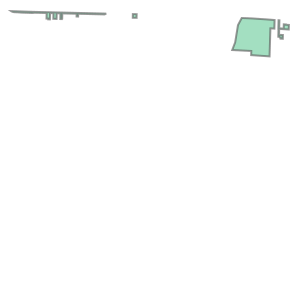

In [29]:
precincts_portland_clackamas_df.loc[2, 'geometry']

In [30]:
list(precincts_portland_clackamas_df.loc[2, 'geometry'].geoms)

[<POLYGON ((7672203.85 661016.1, 7672196.654 660726.039, 7672095.85 660732.33...>,
 <POLYGON ((7672371.007 660736.184, 7672533.391 660726.05, 7672537.214 660880...>,
 <POLYGON ((7667207.624 661117.54, 7667207.6 661116.238, 7667177.726 661116.7...>,
 <POLYGON ((7664224.066 661314.051, 7666079.415 661269.408, 7666106.777 66126...>]

In [31]:
[x.area for x in list(precincts_portland_clackamas_df.loc[2, 'geometry'].geoms)]

[1577187.7481122608, 67255.93741565883, 18093.49462527475, 177223.5656206215]

### Based on the x coordinates and insight from QGIS, the first two are in D1 and the last two are in D3.

In [32]:
poly114_D1 = shapely.unary_union(list(precincts_portland_clackamas_df.loc[2, 'geometry'].geoms)[0:2])
poly114_D3 = shapely.unary_union(list(precincts_portland_clackamas_df.loc[2, 'geometry'].geoms)[2:4])

In [33]:
precincts_portland_clackamas_df.loc[2, 'geometry'] = poly114_D1
precincts_portland_clackamas_df.loc[3, 'geometry'] = poly114_D3


### Now do Washington County:

In [34]:
precincts_portland_washington_df = precincts_portland_washington_df.rename(columns = {'PRECINCTID': 'Precinct'})

In [35]:
precincts_portland_washington_df

,Precinct,geometry
0,W366,"POLYGON ((7627014.371 682448.730, 7627005.638 ..."
1,W441,"POLYGON ((7626189.857 657317.552, 7626184.807 ..."
2,W375,"MULTIPOLYGON (((7619251.703 687748.276, 761924..."
3,W391,"MULTIPOLYGON (((7626567.152 664541.219, 762654..."
4,W392,"MULTIPOLYGON (((7622540.505 673661.625, 762256..."


In [36]:
precincts_portland_washington_df.insert(1, 'District', None)
for i in precincts_portland_washington_df.index:
    precincts_portland_washington_df.loc[i, 'District'] = '4'

In [37]:
precincts_portland_washington_df

,Precinct,District,geometry
0,W366,4,"POLYGON ((7627014.371 682448.730, 7627005.638 ..."
1,W441,4,"POLYGON ((7626189.857 657317.552, 7626184.807 ..."
2,W375,4,"MULTIPOLYGON (((7619251.703 687748.276, 761924..."
3,W391,4,"MULTIPOLYGON (((7626567.152 664541.219, 762654..."
4,W392,4,"MULTIPOLYGON (((7622540.505 673661.625, 762256..."


### Now for the fun part - merging all the splits in the Multnomah precincts!

In [38]:
precincts_multnomah_all_splits_df

,OR_House,OR_Senate,Unincorp,METRO,Mult_Comm,CITY,TRAN_DIST,FIRE_DIST,WaterDist,SewerDist,SchoolDist,PUD,CommColleg,Soil_Water,USCongress,ESD,CoP_Dist,UFSWQD,Precinct,Split,Shape_Leng,Shape_Area,geometry
0,House District 44,Senate District 22,Multnomah Co Unincorporated,Metro District 5,Multnomah Co Commissioner District 4,None,Tri-County Metropolitan Transportation Distric...,None,None,None,Reynolds School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 5,None,None,4407,C,34012.975023,4.729440e+07,"POLYGON ((7678756.031 703492.129, 7678614.458 ..."
1,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 4,1,None,4407,A,27449.132678,1.971331e+07,"POLYGON ((7655881.390 715353.419, 7659490.186 ..."
2,House District 41,Senate District 21,None,Metro District 6,Multnomah Co Commissioner District 3,City of Milwaukie,Tri-County Metropolitan Transportation Distric...,Clackamas Fire District #1,None,None,Portland School District,None,Portland Community College Zone 3,EAST MULT. SOIL & WATER 2,Congressional District 5,ESD Multnomah Zone 3,None,UFSWQD,4101,B,1441.775590,1.005460e+05,"POLYGON ((7660577.340 661426.638, 7660573.392 ..."
3,House District 41,Senate District 21,None,Metro District 6,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 3,EAST MULT. SOIL & WATER 2,Congressional District 5,ESD Multnomah Zone 3,4,UFSWQD,4102,1,19297.505114,1.412378e+07,"POLYGON ((7652341.182 662928.174, 7652319.165 ..."
4,House District 44,Senate District 22,Multnomah Co Unincorporated,Metro District 5,Multnomah Co Commissioner District 2,None,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 2,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 1,None,UFSWQD,4402,B,37971.748319,6.638600e+07,"POLYGON ((7640566.512 720316.420, 7639906.667 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,House District 33,Senate District 17,None,Metro District 5,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 4,WEST MULT. SOIL & WATER 4,Congressional District 1,ESD Multnomah Zone 2,None,UFSWQD,3304,B,2970.314985,3.878391e+05,"POLYGON ((7623459.837 685077.233, 7623125.837 ..."
291,House District 45,Senate District 23,None,Metro District 1,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Reynolds School District,None,Mt Hood Community College Zone 3,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 5,1,UFSWQD,4509,B,20817.521254,1.334270e+07,"POLYGON ((7687150.174 690950.941, 7687124.410 ..."
292,House District 34,Senate District 17,None,Metro District 5,Multnomah Co Commissioner District 1,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 4,WEST MULT. SOIL & WATER 4,Congressional District 1,ESD Multnomah Zone 2,4,UFSWQD,3401,1,21257.603653,5.862246e+06,"POLYGON ((7619470.434 694309.317, 7619503.610 ..."
293,House District 44,Senate District 22,None,Metro District 5,Multnomah Co Commissioner District 2,Portland,Tri-County Metropolitan Transportation Distric...,None,None,None,Portland School District,None,Portland Community College Zone 2,EAST MULT. SOIL & WATER 1,Congressional District 3,ESD Multnomah Zone 1,2,None,4406,C,7390.683209,1.906596e+06,"POLYGON ((7655419.461 712385.788, 7655404.800 ..."


In [39]:
precincts_portland_multnomah_df = gpd.GeoDataFrame(columns = ['Precinct', 'District', 'geometry'], crs = precincts_multnomah_all_splits_df.crs) 

precinct_nums = sorted(list(set(precincts_multnomah_all_splits_df['Precinct'])))
district_nums = ['1', '2', '3', '4']

In [40]:
for pnum in precinct_nums:
    this_precinct_df = precincts_multnomah_all_splits_df[precincts_multnomah_all_splits_df['Precinct'] == pnum]
    for dnum in district_nums:
        this_precinct_district_df = this_precinct_df[this_precinct_df['CoP_Dist'] == dnum]

        if len(this_precinct_district_df) > 0:
            this_geom = shapely.unary_union(this_precinct_district_df['geometry'])
            this_df = gpd.GeoDataFrame({'Precinct': ['M'+pnum], 'District': [dnum], 'geometry': [this_geom]}, crs = precincts_multnomah_all_splits_df.crs)
            precincts_portland_multnomah_df = pd.concat([precincts_portland_multnomah_df, this_df], ignore_index = True)
                                            

In [41]:
precincts_portland_multnomah_df

,Precinct,District,geometry
0,M2801,4,"POLYGON ((7646225.790 678863.128, 7646234.372 ..."
1,M2803,4,"POLYGON ((7641208.338 681390.862, 7641460.306 ..."
2,M2804,4,"MULTIPOLYGON (((7635552.653 676438.108, 763565..."
3,M2805,4,"POLYGON ((7635903.322 668707.324, 7635895.679 ..."
4,M2806,4,"POLYGON ((7641283.843 665156.055, 7641185.318 ..."
...,...,...,...
84,M4806,1,"POLYGON ((7691011.020 676362.385, 7691082.344 ..."
85,M4809,1,"POLYGON ((7675296.268 671016.906, 7675132.605 ..."
86,M4910,1,"MULTIPOLYGON (((7690256.288 682006.379, 769025..."
87,M5001,1,"POLYGON ((7693717.194 679607.462, 7693716.802 ..."


### ALERT!!  From vote tallies in the CVRs, there are two precincts here that have the wrong district labels!

In [42]:
precincts_portland_multnomah_df[precincts_portland_multnomah_df['Precinct'].isin(['M4103', 'M4603'])]

,Precinct,District,geometry
21,M4103,3,"POLYGON ((7655973.687 672058.852, 7655995.243 ..."
63,M4603,1,"POLYGON ((7669050.640 671694.473, 7669040.883 ..."


### 4103 only has votes from D4 and 4603 only has votes from D3, so fix these two!

In [43]:
precincts_portland_multnomah_df.loc[21, 'District'] = 4
precincts_portland_multnomah_df.loc[63, 'District'] = 3

In [44]:
precincts_portland_multnomah_df[precincts_portland_multnomah_df['Precinct'].isin(['M4103', 'M4603'])]

,Precinct,District,geometry
21,M4103,4,"POLYGON ((7655973.687 672058.852, 7655995.243 ..."
63,M4603,3,"POLYGON ((7669050.640 671694.473, 7669040.883 ..."


### Now put them all together!

In [45]:
precincts_portland_df = pd.concat([precincts_portland_multnomah_df, precincts_portland_clackamas_df, precincts_portland_washington_df]).reset_index(drop = True)

In [46]:
maup.doctor(precincts_portland_df)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 2280.72it/s]

There are 72 overlaps.
There are 316 holes.


False

### Figures.  But since we're not doing gerrychain on this, we don't have to care unless there's a failure of maup.assign of blocks to districts. 
### We should put our population data on the city block file to make this easier.  

In [47]:
OR_blocks_df = gpd.read_file("./Data/Shapefiles/OR_blocks/OR_blocks_with_VAP_and_DVAP.shp")

In [48]:
portland_blocks_df = gpd.read_file("./Data/Shapefiles/FLO_Analytics_Portland_Oregon_Districtr_Shapefiles_20230217/tl_2020_41_tabblock20.shp")

In [49]:
OR_blocks_df

,GEOID20,TRACT20,COUNTY,TOTPOP20,VAP20,HVAP20,AAPIVAP20,BVAP20,AMINVAP20,WVAP20,DVAP22,HDVAP22,AAPIDVAP22,BDVAP22,AMINDVAP22,WDVAP22,geometry
0,410159502021019,41015950202,015,28,25,5,3,0,2,15,22.603070,3.588974,2.177912,0.0,1.836184,15.0,"POLYGON ((381984.191 4699027.367, 382002.116 4..."
1,410159501001119,41015950100,015,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,"POLYGON ((436012.074 4727244.332, 436024.255 4..."
2,410159503014130,41015950301,015,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,"POLYGON ((399913.496 4686997.533, 399922.854 4..."
3,410159504012139,41015950401,015,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,"POLYGON ((401192.869 4650258.068, 401208.325 4..."
4,410159501001102,41015950100,015,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,"POLYGON ((435928.882 4732753.897, 435946.840 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130802,410079509002019,41007950900,007,2,1,1,0,0,0,0,0.510776,0.510776,0.000000,0.0,0.000000,0.0,"POLYGON ((429212.639 5094500.854, 429213.744 5..."
130803,410079511001096,41007951100,007,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,"POLYGON ((429400.315 5094639.159, 429404.761 5..."
130804,410579601021015,41057960102,057,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,"POLYGON ((471590.317 5067944.266, 471595.282 5..."
130805,410579601021079,41057960102,057,1,1,0,0,0,1,0,1.000000,0.000000,0.000000,0.0,1.000000,0.0,"POLYGON ((434416.044 5066649.077, 434428.579 5..."


In [50]:
portland_blocks_df

,GEOID20,P0010001,P0020001,P0020002,P0020005,P0020006,P0020007,P0020008,P0020009,P0020010,P0020011,P0040001,P0040002,P0040005,P0040006,P0040007,P0040008,P0040009,P0040010,P0040011,CVAP_01,CVAP_03,CVAP_04,CVAP_05,CVAP_06,CVAP_07,CVAP_08,CVAP_13,Precinct,geometry
0,410050201011000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,C104,"POLYGON ((-122.69820 45.43304, -122.69795 45.4..."
1,410050201011001,10,10,2,2,0,0,3,0,0,3,7,2,0,0,0,2,0,0,3,6.341912,5.009191,0.000000,0.0,0.321691,0.0,0.091912,0.873162,C104,"POLYGON ((-122.69870 45.43282, -122.69870 45.4..."
2,410050201011006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,C104,"POLYGON ((-122.70204 45.43298, -122.70200 45.4..."
3,410050208001022,16,16,1,15,0,0,0,0,0,0,16,1,15,0,0,0,0,0,0,9.631068,9.165049,0.000000,0.0,0.000000,0.0,0.258900,0.207120,C104,"POLYGON ((-122.64820 45.45573, -122.64780 45.4..."
4,410050208001023,22,22,1,21,0,0,0,0,0,0,22,1,21,0,0,0,0,0,0,13.242718,12.601942,0.000000,0.0,0.000000,0.0,0.355987,0.284790,C104,"POLYGON ((-122.65292 45.45832, -122.65258 45.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12351,410670305023003,171,171,37,117,7,0,7,0,1,2,155,26,114,7,0,7,0,0,1,114.528222,107.325190,1.440607,0.0,0.000000,0.0,2.881213,2.881213,W391,"POLYGON ((-122.75450 45.46471, -122.75449 45.4..."
12352,410670305023005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,W391,"POLYGON ((-122.75480 45.46475, -122.75471 45.4..."
12353,410670306003009,45,45,5,26,1,0,8,1,0,4,44,5,26,1,0,8,1,0,3,27.044808,24.644381,1.280228,0.0,1.120199,0.0,0.000000,0.000000,W441,"POLYGON ((-122.74571 45.44479, -122.74571 45.4..."
12354,410670306003010,33,33,1,27,0,0,0,0,0,5,27,0,23,0,0,0,0,0,4,19.832859,18.072546,0.938834,0.0,0.821479,0.0,0.000000,0.000000,W441,"POLYGON ((-122.74528 45.44490, -122.74524 45.4..."


### The Oregon blocks file has the population data in the format that we want, so let's just pull off the subset of Oregon blocks with GEOIDs in the Portland blocks file.

In [51]:
portland_blocks_with_pop_df = OR_blocks_df[OR_blocks_df['GEOID20'].isin(list(portland_blocks_df['GEOID20']))].reset_index(drop=True)

In [52]:
portland_blocks_with_pop_df

,GEOID20,TRACT20,COUNTY,TOTPOP20,VAP20,HVAP20,AAPIVAP20,BVAP20,AMINVAP20,WVAP20,DVAP22,HDVAP22,AAPIDVAP22,BDVAP22,AMINDVAP22,WDVAP22,geometry
0,410670305021007,41067030502,067,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"POLYGON ((519839.917 5034715.986, 519859.931 5..."
1,410510090014003,41051009001,051,195,149,33,37,3,0,76,117.614790,16.157676,24.904828,3.0,0.000000,73.552286,"POLYGON ((536111.740 5036879.340, 536112.291 5..."
2,410510057011013,41051005701,051,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"POLYGON ((525177.777 5039069.840, 525178.391 5..."
3,410510038023003,41051003802,051,29,22,1,3,2,2,14,20.803697,0.833333,2.365385,2.0,2.000000,13.604979,"POLYGON ((524237.242 5047112.186, 524260.881 5..."
4,410510002022034,41051000202,051,69,50,0,2,0,0,48,47.781292,0.000000,1.448276,0.0,0.000000,46.333016,"POLYGON ((527517.281 5035844.683, 527594.553 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12351,410510009023013,41051000902,051,45,34,4,6,0,0,24,30.817460,3.817460,3.000000,0.0,0.000000,24.000000,"POLYGON ((528238.651 5037823.002, 528315.225 5..."
12352,410510050012010,41051005001,051,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"POLYGON ((524647.677 5041725.004, 524650.410 5..."
12353,410050222084002,41005022208,005,29,25,3,1,0,1,20,24.257661,3.000000,0.761392,0.0,1.000000,19.496269,"POLYGON ((537785.372 5034236.441, 537789.220 5..."
12354,410510008024001,41051000802,051,95,82,7,13,3,4,55,74.701149,4.116832,8.911950,3.0,3.672367,55.000000,"POLYGON ((529776.976 5038228.625, 529777.210 5..."


In [53]:
portland_blocks_with_pop_df = portland_blocks_with_pop_df.to_crs(precincts_portland_df.crs)

### Now try maup assign and hope for the best!

In [54]:
block_assignment = maup.assign(portland_blocks_with_pop_df, precincts_portland_df)

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 569.01it/s]


In [55]:
block_assignment[block_assignment.isna()]

1166    NaN
1842    NaN
2416    NaN
3012    NaN
3562    NaN
4151    NaN
4200    NaN
5676    NaN
5900    NaN
6002    NaN
6724    NaN
6896    NaN
7408    NaN
7791    NaN
8741    NaN
11144   NaN
11599   NaN
11846   NaN
12331   NaN
dtype: float64

### Dammit!!!

In [56]:
bad_blocks_df = portland_blocks_with_pop_df[portland_blocks_with_pop_df.index.isin(block_assignment[block_assignment.isna()].index)]
bad_blocks_df['TOTPOP20'].sum()

0

### Okay, FINE, we can ignore the unassigned blocks with zero population.

In [57]:
portland_blocks_with_pop_df.columns

Index(['GEOID20', 'TRACT20', 'COUNTY', 'TOTPOP20', 'VAP20', 'HVAP20',
       'AAPIVAP20', 'BVAP20', 'AMINVAP20', 'WVAP20', 'DVAP22', 'HDVAP22',
       'AAPIDVAP22', 'BDVAP22', 'AMINDVAP22', 'WDVAP22', 'geometry'],
      dtype='object')

In [58]:
pop_vars = ['TOTPOP20', 'VAP20', 'HVAP20', 'AAPIVAP20', 'BVAP20', 'AMINVAP20', 'WVAP20', 'DVAP22', 'HDVAP22',
            'AAPIDVAP22', 'BDVAP22', 'AMINDVAP22', 'WDVAP22']

In [59]:
precincts_portland_df[pop_vars] = portland_blocks_with_pop_df[pop_vars].groupby(block_assignment).sum()

In [60]:
precincts_portland_df

,Precinct,District,geometry,TOTPOP20,VAP20,HVAP20,AAPIVAP20,BVAP20,AMINVAP20,WVAP20,DVAP22,HDVAP22,AAPIDVAP22,BDVAP22,AMINDVAP22,WDVAP22
0,M2801,4,"POLYGON ((7646225.790 678863.128, 7646234.372 ...",10999.0,9413.0,586.0,828.0,251.0,177.0,7571.0,8928.145443,495.835034,669.800544,228.974554,163.761479,7369.773831
1,M2803,4,"POLYGON ((7641208.338 681390.862, 7641460.306 ...",5871.0,5616.0,535.0,877.0,260.0,58.0,3886.0,4896.897756,396.813936,421.721823,211.065934,58.000000,3809.296063
2,M2804,4,"MULTIPOLYGON (((7635552.653 676438.108, 763565...",10149.0,8180.0,453.0,626.0,206.0,121.0,6774.0,7601.405212,364.290247,355.768553,204.256966,115.594061,6561.495386
3,M2805,4,"POLYGON ((7635903.322 668707.324, 7635895.679 ...",11679.0,9234.0,420.0,601.0,148.0,145.0,7920.0,8925.599779,374.374161,455.492848,129.306818,135.938796,7830.487157
4,M2806,4,"POLYGON ((7641283.843 665156.055, 7641185.318 ...",12941.0,10552.0,760.0,732.0,383.0,173.0,8504.0,9980.090803,652.105546,597.742948,352.410132,158.786795,8219.045382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,W366,4,"POLYGON ((7627014.371 682448.730, 7627005.638 ...",8.0,6.0,1.0,1.0,0.0,0.0,4.0,5.799405,1.000000,0.895105,0.000000,0.000000,3.904300
96,W441,4,"POLYGON ((7626189.857 657317.552, 7626184.807 ...",105.0,92.0,5.0,17.0,1.0,0.0,69.0,87.822338,4.526462,13.735099,1.000000,0.000000,68.560776
97,W375,4,"MULTIPOLYGON (((7619251.703 687748.276, 761924...",454.0,330.0,19.0,75.0,9.0,6.0,221.0,304.989320,19.000000,50.480769,9.000000,5.508551,221.000000
98,W391,4,"MULTIPOLYGON (((7626567.152 664541.219, 762654...",942.0,775.0,119.0,61.0,29.0,12.0,554.0,753.745707,111.830138,51.357264,29.000000,12.000000,549.558304


### Check the sums:

In [61]:
portland_blocks_with_pop_df[pop_vars].sum()

TOTPOP20      652503.000000
VAP20         541274.000000
HVAP20         52271.000000
AAPIVAP20      57910.000000
BVAP20         34552.000000
AMINVAP20      11208.000000
WVAP20        385333.000000
DVAP22        505542.801066
HDVAP22        40554.920286
AAPIDVAP22     45196.947903
BDVAP22        32082.293238
AMINDVAP22     10505.019821
WDVAP22       377203.619819
dtype: float64

In [62]:
precincts_portland_df[pop_vars].sum()

TOTPOP20      652503.000000
VAP20         541274.000000
HVAP20         52271.000000
AAPIVAP20      57910.000000
BVAP20         34552.000000
AMINVAP20      11208.000000
WVAP20        385333.000000
DVAP22        505542.801066
HDVAP22        40554.920286
AAPIDVAP22     45196.947903
BDVAP22        32082.293238
AMINDVAP22     10505.019821
WDVAP22       377203.619819
dtype: float64

### Reorder the columns and save!

In [63]:
precincts_portland_df.columns

Index(['Precinct', 'District', 'geometry', 'TOTPOP20', 'VAP20', 'HVAP20',
       'AAPIVAP20', 'BVAP20', 'AMINVAP20', 'WVAP20', 'DVAP22', 'HDVAP22',
       'AAPIDVAP22', 'BDVAP22', 'AMINDVAP22', 'WDVAP22'],
      dtype='object')

In [64]:
precincts_portland_df = precincts_portland_df[['Precinct', 'District', 'TOTPOP20', 'VAP20', 'HVAP20', 
                                               'AAPIVAP20', 'BVAP20', 'AMINVAP20', 'WVAP20', 'DVAP22', 'HDVAP22', 
                                               'AAPIDVAP22', 'BDVAP22', 'AMINDVAP22', 'WDVAP22', 'geometry']]

### A later step found a population issue in this precinct:

In [66]:
precincts_portland_df[precincts_portland_df['Precinct'] == 'M3301']

,Precinct,District,TOTPOP20,VAP20,HVAP20,AAPIVAP20,BVAP20,AMINVAP20,WVAP20,DVAP22,HDVAP22,AAPIDVAP22,BDVAP22,AMINDVAP22,WDVAP22,geometry
5,M3301,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((7612089.162 719216.635, 7612087.020 ..."


### Looks like this is a tiny precinct that had no census blocks assigned to it by Maup.  Need to zero it out before saving.

In [67]:
precincts_portland_df = precincts_portland_df.fillna(0)

In [68]:
precincts_portland_df[precincts_portland_df['Precinct'] == 'M3301']

,Precinct,District,TOTPOP20,VAP20,HVAP20,AAPIVAP20,BVAP20,AMINVAP20,WVAP20,DVAP22,HDVAP22,AAPIDVAP22,BDVAP22,AMINDVAP22,WDVAP22,geometry
5,M3301,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((7612089.162 719216.635, 7612087.020 ..."


In [69]:
precincts_portland_df.to_file("./Data/Shapefiles/Portland precincts with pop/Portland_precincts_with_pop.shp")